In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import numpy as np
import pylab as plt

import pandas as pd

from astropy.time import Time
from natsort import natsorted

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from lassi_time import dt2tuple
from SamplerData import SamplerData

In [3]:
fitsDir = '/home/gbtdata/TLASSI_200315'

In [4]:
fits_files = natsorted(glob.glob("{0}/LASSI/*.fits".format(fitsDir)))[19:-12]

In [5]:
fits_files[0]

'/home/gbtdata/TLASSI_200315/LASSI/2020_03_16_02:21:06.fits'

In [6]:
dates = ['{0}T{1}'.format('-'.join(fn.split('/')[-1].split('.')[0].split("_")[:3]), 
                          fn.split('/')[-1].split('.')[0].split("_")[-1]) for fn in fits_files]
dates = Time(dates)

In [7]:
start = dt2tuple(dates[0].datetime)
end = dt2tuple(dates[-1].datetime)
time_range = (start, end)
print(time_range)

((2020, 3, 16, 2, 21, 6), (2020, 3, 16, 9, 26, 7))


In [8]:
w2sd = SamplerData("Weather-Weather2-weather2", False)
w3sd = SamplerData("Weather-Weather3-weather3", False)
a1sd = SamplerData("Accelerometer-Accelerometer1-AccelerometerData", False)
qdsd = SamplerData("QuadrantDetector-QuadrantDetector-QuadrantDetectorData", False)
stsd = SamplerData("AntennaCharacterization-StructureTemperature-StructureTemp", False)

In [9]:
cols = (0,)
exprs = ('X',)
dmjds = stsd.GetPlotData(time_range, cols, exprs)
temps = np.empty((24, len(dmjds[0])), dtype=np.float)
for i in range(1,25):
    cols = (0,i)
    exprs = ('X','Y1')
    _, temps[i-1] = stsd.GetPlotData(time_range, cols, exprs)

cols = (0,1)
exprs = ('X','Y1')
dmjdsw3, wvms3 = w3sd.GetPlotData(time_range, cols, exprs)

cols = (0,1)
exprs = ('X','Y1')
dmjdsw2, wvms2 = w2sd.GetPlotData(time_range, cols, exprs)

cols = (0,)

exprs = ('X',)

mjda1 = a1sd.GetPlotData(time_range, cols, exprs)
acc1 = np.empty((3, len(mjda1[0])), dtype=np.float)
for i in range(1,4):
    cols = (0,i)
    exprs = ('X','Y1')
    _, acc1[i-1] = a1sd.GetPlotData(time_range, cols, exprs)
    
cols = (0,)
exprs = ('X',)
mjdqd = qdsd.GetPlotData(time_range, cols, exprs)
qdd = np.empty((3, len(mjdqd[0])), dtype=np.float)
for i,c_ in enumerate([12,13,14]):
    cols = (0,c_)
    exprs = ('X','Y1')
    _, qdd[i] = qdsd.GetPlotData(time_range, cols, exprs)

In [10]:
df = pd.DataFrame(np.sqrt(np.sum(np.power(acc1, 2.), axis=0)), columns=['a'])
acc_std = df['a'].rolling(5).std()

In [11]:
df = pd.DataFrame(qdd[2]*3600., columns=['a'])
qdd_std = df['a'].rolling(5).std()

In [12]:
temp_t = Time(dmjds[0], format='mjd')
wind2_t = Time(dmjdsw2, format='mjd')
wind3_t = Time(dmjdsw3, format='mjd')
acc1_t = Time(mjda1[0], format='mjd')
qdd_t = Time(mjdqd[0], format='mjd')

<IPython.core.display.Javascript object>


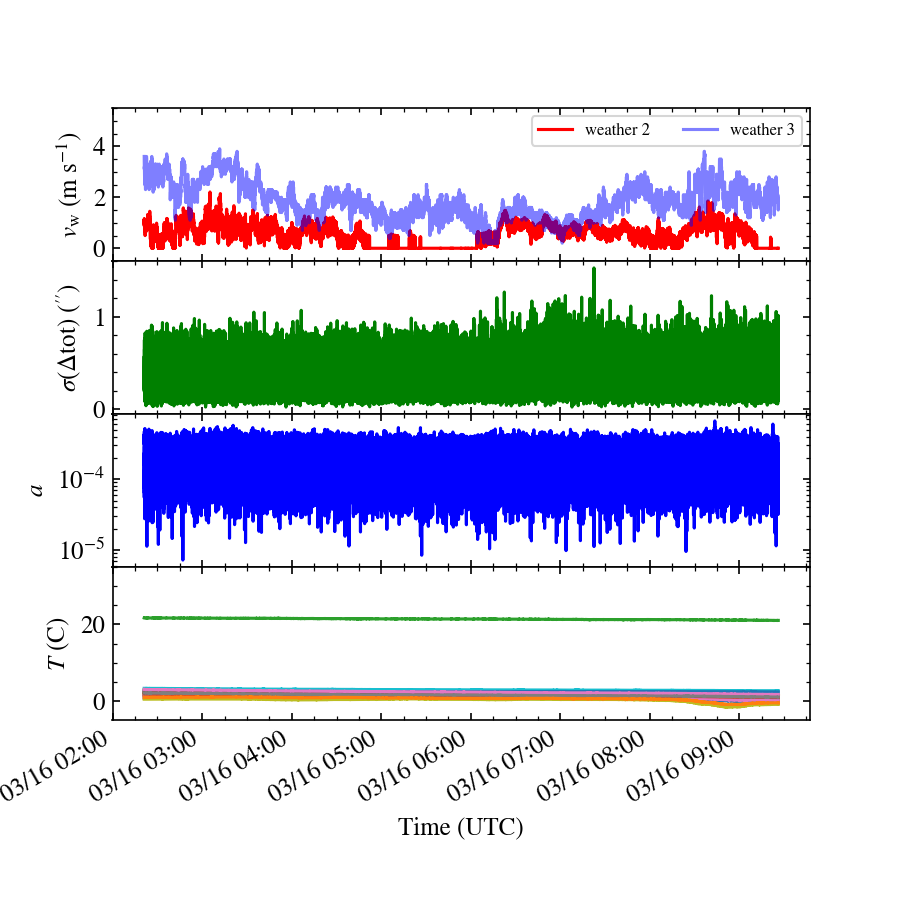

In [16]:
from matplotlib.dates import DateFormatter
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('font', **{'family':'STIXGeneral', 'weight':'normal'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams.update({'font.size': 12})

formatter = DateFormatter('%m/%d %H:%M')

fig = plt.figure(figsize=(6,6), dpi=150)
plt.subplots_adjust(wspace=0., hspace=0.)

#ax2.plot_date([(sunset + utc_to_east).plot_date]*2, ax2.get_ylim(), ':', color='#f78112')
#ax2.plot_date([(sunrise + utc_to_east).plot_date]*2, ax2.get_ylim(), ':', color='#a412f7')

ax2 = fig.add_subplot(411)

ax2.plot_date(wind2_t.plot_date, wvms2, 'r-', label='weather 2')
ax2.plot_date(wind3_t.plot_date, wvms3, 'b-', alpha=0.5, label='weather 3')

ax2.legend(loc=0, fancybox=True, ncol=3, fontsize=8)

ax2.minorticks_on()
ax2.tick_params('both', direction='in', which='both', top=True, right=True, left=True, bottom=True)
ax2.set_ylabel('$v_{\mathrm{w}}$ (m s$^{-1}$)')
ax2.xaxis.set_major_formatter(formatter)
ax2.set_ylim(-0.5, 5.5)

ax3 = fig.add_subplot(412, sharex=ax2)

#ax3.plot_date(qdd_t.plot_date, qdd[2]*3600., 'g-')
ax3.plot_date(qdd_t.plot_date, qdd_std, 'g-')
ax3.minorticks_on()
ax3.tick_params('both', direction='in', which='both', top=True, right=True, left=True, bottom=True)
ax3.set_ylabel(r'$\sigma(\Delta\mathrm{tot})$ ($^{\prime\prime}$)')

ax4 = fig.add_subplot(413, sharex=ax2)

#ax5.plot_date(acc1_t.plot_date, np.sqrt(np.sum(np.power(acc1, 2.), axis=0)), ls='-', marker='', c='b')
ax4.plot_date(acc1_t.plot_date, acc_std, ls='-', marker='', c='b')

ax4.minorticks_on()
ax4.tick_params('both', direction='in', which='both', top=True, right=True, left=True, bottom=True)
ax4.set_ylabel('$a$')
ax4.xaxis.set_major_formatter(formatter)
ax4.semilogy()
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10), numticks=10) 
ax4.yaxis.set_minor_locator(locmin)


ax5 = fig.add_subplot(414, sharex=ax2)

for i in range(1,24):
    #if i==9 or i == 10 or i == 21:# or i == 22:
    ax5.plot((temp_t).plot_date, temps[i], label='col {0}'.format(i+1), ls='-')

ax5.set_ylim(-5, 35)

#ax5.legend(loc=0, fancybox=True, ncol=3)

ax5.minorticks_on()
ax5.tick_params('both', direction='in', which='both', top=True, right=True, left=True, bottom=True)
ax5.set_ylabel('$T$ (C)')
    
ax5.xaxis.set_major_formatter(formatter)
ax5.set_xlabel('Time (UTC)')

fig.autofmt_xdate()

plt.savefig('March2020_sensors.pdf',
            bbox_inches='tight',
            pad_inches=0.06)